In [1]:
import os
import cv2
import json
import numpy as np
import random
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
from models_lib.pose_model import SimCC, PoseSimCC
from dataset.dataset import SimCCDataset
from core.loss import SimCCLoss

# Load dataset and preprocessing

In [3]:
def custom_collate(batch):
    images, keypoints, keypoint_x_labels, keypoint_y_labels, keypoint_weights = [], [], [], [], []
    for img_set, kp_set, encoded in batch:
        images.extend(img_set)
        keypoints.extend(kp_set)
        keypoint_x_labels.extend(torch.tensor(encoded['keypoints_x_labels']))
        keypoint_y_labels.extend(torch.tensor(encoded['keypoints_y_labels']))
        keypoint_weights.extend(torch.tensor(encoded['keypoint_weights']))

    images = torch.stack(images)
    keypoints = torch.stack(keypoints)
    keypoint_x_labels = torch.stack(keypoint_x_labels)
    keypoint_y_labels = torch.stack(keypoint_y_labels)
    keypoint_weights = torch.stack(keypoint_weights)

    return images, {'keypoints': keypoints, 'keypoint_x_labels': keypoint_x_labels, 'keypoint_y_labels': keypoint_y_labels, 'keypoint_weights': keypoint_weights}

In [4]:
train_data_dir = './train2017'
train_annotation_file = './data/annotations/person_keypoints_train2017.json'
val_data_dir = './val2017'
val_annotation_file = './data/annotations/person_keypoints_val2017.json'

train_dataset_cfg = {
    'input_shape': [192, 256],
    'num_joints': 17,
    'augment': True,
    'grayscale': False,
    'split_ratio': 4.0,
    'sigma': 20.0,
    'weights_normalize': False,
    'min_max_normalize': False,
    'min_max_scale': 25.0
}

val_dataset_cfg = {
    'input_shape': [192, 256],
    'num_joints': 17,
    'augment': False,
    'grayscale': False,
    'split_ratio': 4.0,
    'sigma': 20.0,
    'weights_normalize': False,
    'min_max_normalize': False,
    'min_max_scale': 25.0
}

train_dataset = SimCCDataset(data_dir=train_data_dir, annotation_file=train_annotation_file, dataset_cfg=train_dataset_cfg)
val_dataset = SimCCDataset(data_dir=val_data_dir, annotation_file=val_annotation_file, dataset_cfg=val_dataset_cfg)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate)

# Visualize Data

In [5]:
import matplotlib.pyplot as plt

def visualize_single_image_with_simcc_labels(image, keypoints, simcc_x, simcc_y, split_ratio, visibility=None, keypoint_names=None):
    image = image.numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
    image = (image * 255).astype(np.uint8)
    num_keypoints = simcc_x.shape[0]
    
    fig, axs = plt.subplots(17 // 5 + 1, 5, figsize=(15, (17//5 + 1) * 3))
    axs = axs.flatten()
    
    # Show original image
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    
    # Process and show heatmaps
    for i in range(num_keypoints):
        x_dist = simcc_x[i]
        y_dist = simcc_y[i]

        heatmap = np.zeros((len(y_dist), len(x_dist)))
        for y in range(len(y_dist)):
            for x in range(len(x_dist)):
                heatmap[y, x] = min(y_dist[y], x_dist[x])
        
        heatmap = F.interpolate(
            torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
            scale_factor=1.0/split_ratio,
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        min_val = heatmap.min()
        max_val = heatmap.max()
        if max_val > min_val:
            heatmap = (heatmap - min_val) / (max_val - min_val)  # Normalize the heatmap
        
        heatmap = np.clip(heatmap, 0, 1)

        heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Convert to color heatmap
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        heatmap_color = heatmap_color.astype(np.uint8)
        
        # Create a blended image with transparency
        blended_image = cv2.addWeighted(image, 0.4, heatmap_color, 0.6, 0)
        
        axs[i + 1].imshow(blended_image)
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Heatmap {i+1}')        

    if keypoint_names is not None:
        keypoints_image = image.copy()
        for idx in range(keypoints.shape[0]):
            x, y = keypoints[idx]
            vis = visibility[idx]
            if x > 0 and y > 0 and vis > 0.38:
                cv2.circle(keypoints_image, (int(x), int(y)), 5, (0, 255, 0), -1)
                label = keypoint_names[idx]
                cv2.putText(keypoints_image, label, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)

        plt.figure(figsize=(10, 10))
        plt.imshow(keypoints_image)
        plt.axis('off')
        plt.title('Keypoints on Image')
        plt.show()
    else :
        plt.tight_layout()
        plt.show()

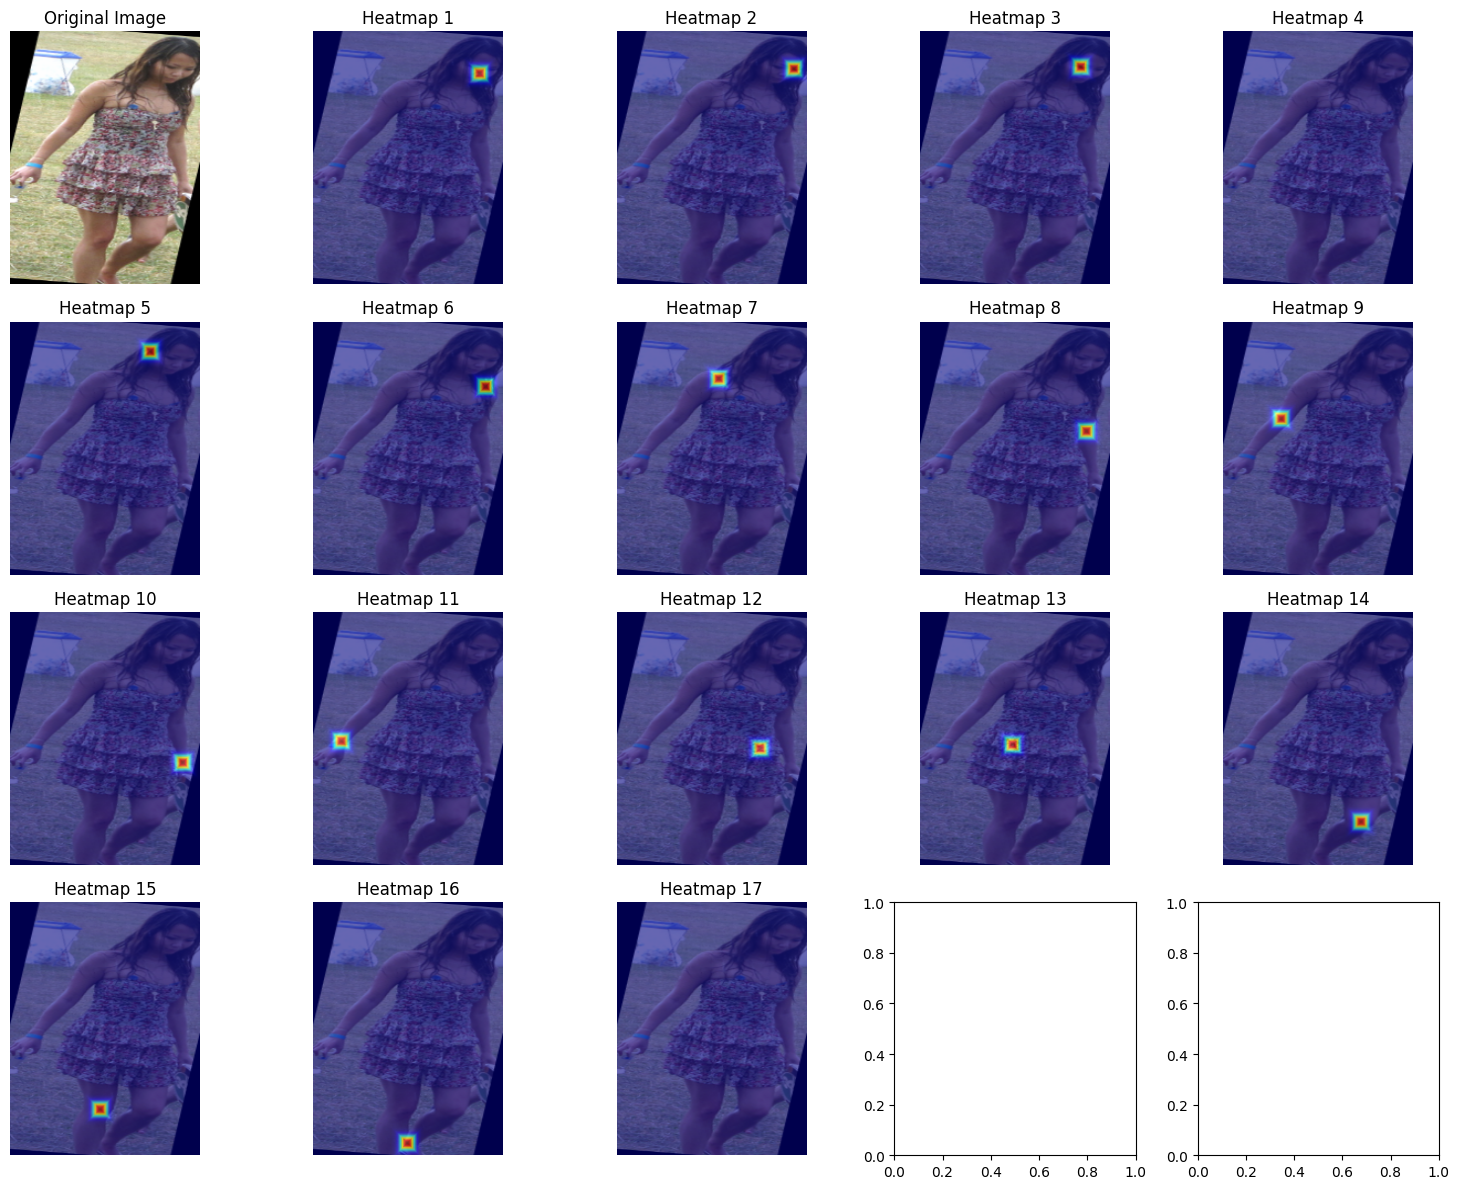

In [6]:
%matplotlib inline

images, targets = next(iter(train_loader))

keypoints = targets['keypoints']
keypoint_x_labels = targets['keypoint_x_labels']
keypoint_y_labels = targets['keypoint_y_labels']
keypoint_weights = targets['keypoint_weights']

visualize_single_image_with_simcc_labels(images[0], keypoints[0], keypoint_x_labels[0], keypoint_y_labels[0], 4.0, None, None)

# Train Model

In [7]:
def save_checkpoint(epoch, batch, model, optimizer, path='./model/pose_simcc.pth'):
    torch.save(model.state_dict(), path)
    print(f" - Checkpoint saved at epoch {epoch + 1}, batch {batch}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_model = True
model_path = './model/pose_simcc_192x256.pth'

deconv_layers_cfg = {
    'num_layers': 2,
    'num_filters': [1024, 512],
    'kernel_sizes': [4, 4],
    'with_bias': False
}

model = PoseSimCC(num_joints=17, input_size=(192, 256), sigma=20.0, split_ratio=4.0, deconv_layers_cfg=deconv_layers_cfg).to(device)

if load_model and os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print("Model loaded from", model_path)

for param in model.backbone.parameters():
    param.requires_grad = False

criterion = SimCCLoss(beta=1.25, use_target_weight=True)

optimizer = optim.Adam(model.parameters(), lr=0.000005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

steps_per_epoch = 1200
validation_steps = 100

num_epochs = 20

for epoch in range(num_epochs): 
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(train_loader):
        if step >= steps_per_epoch:
            break

        keypoints = targets['keypoints']
        keypoint_x_labels = targets['keypoint_x_labels']
        keypoint_y_labels = targets['keypoint_y_labels']
        keypoint_weights = targets['keypoint_weights']

        images = images.to(device)
        keypoint_x_labels = keypoint_x_labels.to(device)
        keypoint_y_labels = keypoint_y_labels.to(device)
        keypoint_weights = keypoint_weights.to(device)

        outputs = model(images)
        loss = criterion(outputs, (keypoint_x_labels, keypoint_y_labels), keypoint_weights)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        sys.stdout.write(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{step+1}/{steps_per_epoch}], Loss: {loss.item():.4f}')
        sys.stdout.flush()

        if (step + 1) % 500 == 0:  # Save model checkpoint every 500 steps
            save_checkpoint(epoch, step + 1, model, optimizer, model_path)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for step, (images, targets) in enumerate(val_loader):
            if step >= validation_steps:
                break

            keypoints = targets['keypoints']
            keypoint_x_labels = targets['keypoint_x_labels']
            keypoint_y_labels = targets['keypoint_y_labels']
            keypoint_weights = targets['keypoint_weights']

            images = images.to(device)
            keypoint_x_labels = keypoint_x_labels.to(device)
            keypoint_y_labels = keypoint_y_labels.to(device)
            keypoint_weights = keypoint_weights.to(device)

            outputs = model(images)
            loss = criterion(outputs, (keypoint_x_labels, keypoint_y_labels), keypoint_weights)
            val_loss += loss.item()

    avg_train_loss = running_loss / steps_per_epoch
    avg_val_loss = val_loss / validation_steps
    print(f'\n Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    # Save the model checkpoint
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

print("Training Complete!")

# Inference Model

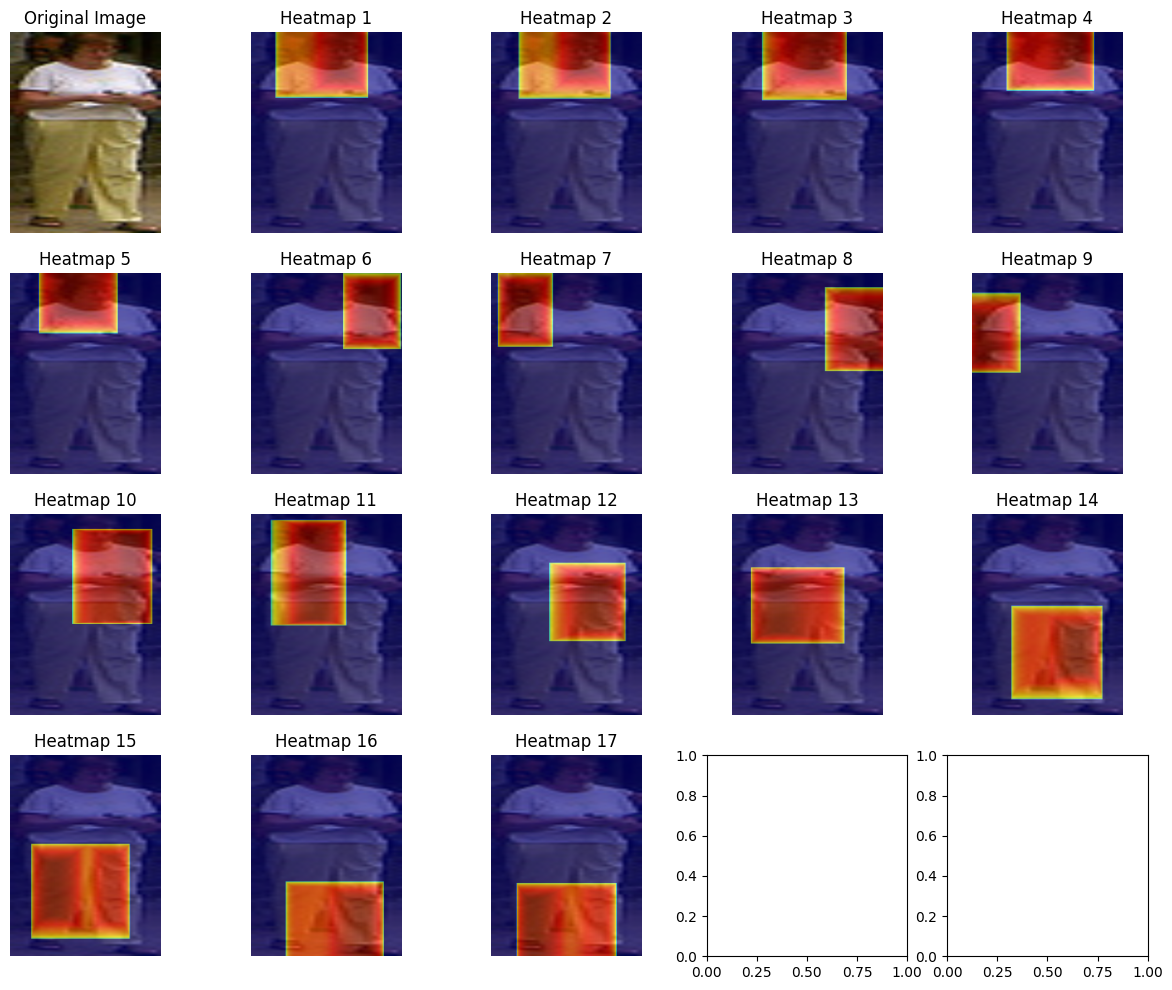

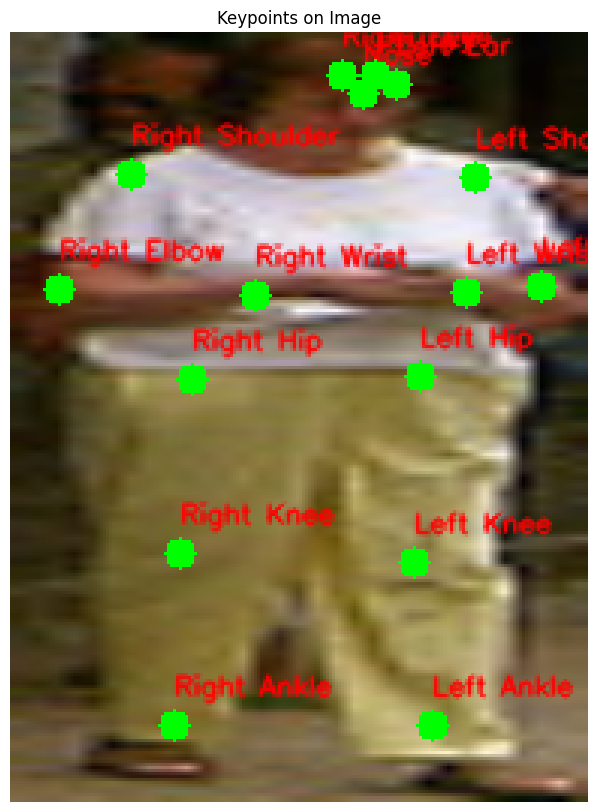

In [12]:
keypoint_names = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
]

images, targets = next(iter(val_loader))

images = images.to(device)
outputs = model.predict(images)

labels, keypoints, eval = outputs
simcc_x, simcc_y = labels
scores, visibility = eval

visualize_single_image_with_simcc_labels(images[0].cpu(), keypoints[0], simcc_x[0], simcc_y[0], 4.0, visibility[0], keypoint_names)

## Convert model to ONNX format (Optional)

In [ ]:
# In case you may want to load the model
model_path = './model/pose_simcc_192x256.pth'

deconv_layers_cfg = {
    'num_layers': 2,
    'num_filters': [1024, 512],
    'kernel_sizes': [4, 4],
    'with_bias': False
}

model = PoseSimCC(num_joints=17, input_size=(192, 256), sigma=20.0, split_ratio=4.0, deconv_layers_cfg=deconv_layers_cfg)
model.load_state_dict(torch.load(model_path))

In [ ]:
torch.onnx.export(
    model,
    torch.rand(1, 3, 256, 192),
    "./model/simcc_192x256.onnx"
)